<a href="https://colab.research.google.com/github/srinivasiyengar/NewCastle-University-Internship/blob/main/Resnet50_dilated_for_Sematic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**labels:** 

wall, sofa, ceiling, door, shelf, floor, fireplace, coffee, table, cushion, mirror, curtain, armchair, flower, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [ ]:
import sys
sys.path.insert(1, "/")

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]


In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

In [ ]:
def resnet50dilated_Sematic_Segmentation (image):
  img_original = numpy.array(image)
  img_data = pil_to_tensor(image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]

  # Run the segmentation at the highest resolution.
  with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
  # Get the predicted scores for each pixel
  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()

  # filter prediction class if requested
  index = None
  if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
  
  # colorize prediction
  pred_color = colorEncode(pred, colors).astype(numpy.uint8)
  return pred_color

In [ ]:
Image_set = []
Noisy_set = []

In [ ]:
img = cv2.imread('/table.jpg')
Image_set.append(img)
gauss = np.random.normal(0,1,img.size)
gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
img_gauss = cv2.add(img,gauss)
Noisy_set.append(img_gauss)

                                          Resnet50 Sematic Segmentation of Original Images

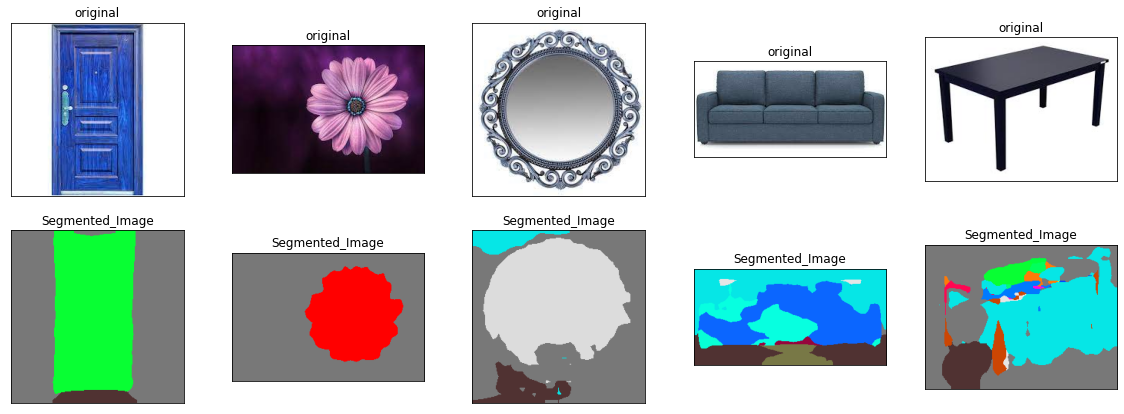

In [ ]:
n = 5 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original") 
  plt.imshow(Image_set[i]) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display segmented image
  bx = plt.subplot(2, n, i + n + 1) 
  plt.title("Segmented_Image") 
  segmented_image = resnet50dilated_Sematic_Segmentation (Image_set[i])
  plt.imshow(segmented_image) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
plt.show()

                                        Resnet50 Sematic Segmentation of Noisy Images

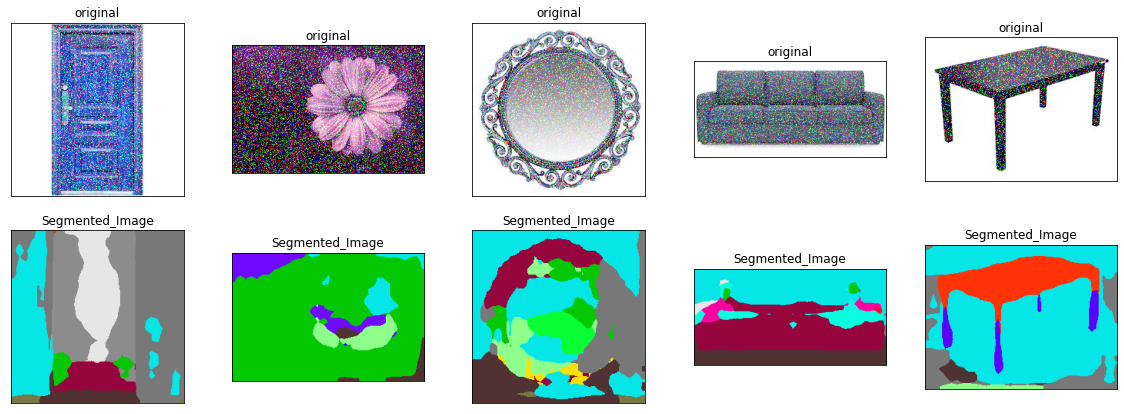

In [ ]:
n = 5 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original") 
  plt.imshow(Noisy_set[i]) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display segmented image
  bx = plt.subplot(2, n, i + n + 1) 
  plt.title("Segmented_Image") 
  segmented_image = resnet50dilated_Sematic_Segmentation (Noisy_set[i])
  plt.imshow(segmented_image) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
plt.show()